**IMPORTING KEY LIBRARIES**

In [1]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

**READING THE HEAD OF THE DATASET**

In [2]:
netflix = pd.read_csv('NFLX.csv')
print(netflix.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2018-01-08  210.020004  212.500000  208.440002  212.050003  212.050003   
1  2018-01-09  212.110001  212.979996  208.589996  209.309998  209.309998   
2  2018-01-10  207.570007  213.639999  206.910004  212.520004  212.520004   
3  2018-01-11  214.289993  217.750000  213.350006  217.240005  217.240005   
4  2018-01-12  217.179993  222.550003  216.000000  221.229996  221.229996   

    Volume  
0  5580200  
1  6125900  
2  5951500  
3  7659500  
4  8199400  


**ADJUSTED CLOSING STOCK PRICE**

In [3]:
netflix=netflix[['Adj Close']]
print(netflix.head())

    Adj Close
0  212.050003
1  209.309998
2  212.520004
3  217.240005
4  221.229996


**LINE GRAPH OF STOCK PRICES FOR 5-YEAR PERIOD**

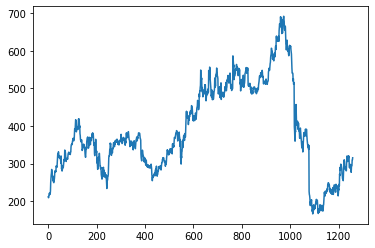

In [4]:
plt.plot(netflix) 
plt.show()

**SETTING RANDOM SEED FOR DEBUGGING AND REPRODUCIBILITY**

In [5]:
# fix random seed for reproducibility
np.random.seed(7)
netflix = netflix.values
netflix = netflix.astype('float32')

**NORMALIZING THE DATASET**

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
netflix = scaler.fit_transform(netflix)

**SPLITTING THE DATASET INTO TRAINING SET AND TEST SET**

In [7]:
# split into train and test sets
train_size = int(len(netflix) * 0.70)
test_size = len(netflix) - train_size
train, test = netflix[0:train_size,:], \
              netflix[train_size:len(netflix),:]
print(len(train), len(test))

881 378


**CONVERTING THE DATASET INTO TIME SERIES PREDICTION MODEL**

In [8]:
#create look back function
def create_netflix(netflix, look_back=1):
    # convert an array of values into a dataset matrix
    dataX, dataY = [], []
    for i in range(len(netflix)-look_back-1):
        a = netflix[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(netflix[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

**RESHAPING THE TEST AND TRAINING DATA**

In [9]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_netflix(train, look_back)
testX, testY = create_netflix(test, look_back)

In [10]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1,
                                trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

**CREATING LSTM NETWORK USING THE TEST AND TRAINING DATA**

In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
879/879 - 3s - loss: 0.0254 - 3s/epoch - 4ms/step
Epoch 2/100
879/879 - 2s - loss: 0.0035 - 2s/epoch - 2ms/step
Epoch 3/100
879/879 - 2s - loss: 5.2823e-04 - 2s/epoch - 2ms/step
Epoch 4/100
879/879 - 2s - loss: 3.9771e-04 - 2s/epoch - 2ms/step
Epoch 5/100
879/879 - 2s - loss: 4.1125e-04 - 2s/epoch - 2ms/step
Epoch 6/100
879/879 - 1s - loss: 4.0699e-04 - 1s/epoch - 2ms/step
Epoch 7/100
879/879 - 2s - loss: 4.1814e-04 - 2s/epoch - 2ms/step
Epoch 8/100
879/879 - 1s - loss: 4.1667e-04 - 1s/epoch - 2ms/step
Epoch 9/100
879/879 - 2s - loss: 4.2071e-04 - 2s/epoch - 2ms/step
Epoch 10/100
879/879 - 1s - loss: 4.1540e-04 - 1s/epoch - 2ms/step
Epoch 11/100
879/879 - 2s - loss: 4.1263e-04 - 2s/epoch - 2ms/step
Epoch 12/100
879/879 - 2s - loss: 4.2434e-04 - 2s/epoch - 2ms/step
Epoch 13/100
879/879 - 2s - loss: 4.1765e-04 - 2s/epoch - 2ms/step
Epoch 14/100
879/879 - 2s - loss: 4.0980e-04 - 2s/epoch - 2ms/step
Epoch 15/100
879/879 - 2s - loss: 4.2933e-04 - 2s/epoch - 2ms/step
Epoch 16/100

**MAKING PREDICTIONS USING THE TRAINED LSTM MODEL**

In [12]:
#predicting and inverse transforming the predictions
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

12/12 [==============================] - 0s 2ms/step
Train Score: 10.80 RMSE
Test Score: 14.40 RMSE


In [13]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(netflix)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(netflix)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(netflix)-1, :] = testPredict

**PLOTTING THE ORIGINAL DATASET, THE TRAINING SET PREDICTIONS, AND THE TEST SET PREDICTIOONS**

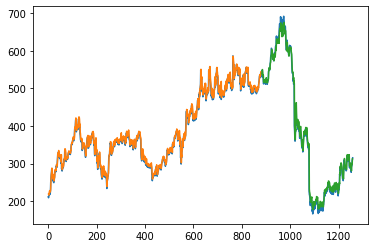

In [14]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(netflix))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

**COMPARING THE ACTUAL TO THE PREDICTED STOCK PRICES**

In [15]:
#comparison of actual and predicted
actual = np.append(trainY, testY)
predicted = np.append(trainPredict, testPredict)
result_df =pd.DataFrame()
result_df['Actual_Y']= actual
result_df['Predicted_Y']=predicted
print(result_df.head())

     Actual_Y  Predicted_Y
0  209.309994   218.930756
1  212.520004   216.416885
2  217.240011   219.362854
3  221.229990   223.716064
4  221.530001   227.415451


In [ ]:
### End of Question 3b

In [ ]:
netflix_wd = pd.read_csv('NFLX.csv')
netflix_wd.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600
1,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200
2,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200
3,2018-01-09,212.110001,212.979996,208.589996,209.309998,209.309998,6125900
4,2018-01-10,207.570007,213.639999,206.910004,212.520004,212.520004,5951500


In [ ]:
netflix_x = netflix_wd.loc[(netflix_wd['Date'] >= '2022-01-01') & (netflix_wd['Date'] < '2023-01-01')]
netflix_x.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1006,2022-01-03,605.609985,609.989990,590.559998,597.369995,597.369995,3067500
1007,2022-01-04,599.909973,600.409973,581.599976,591.150024,591.150024,4393100
1008,2022-01-05,592.000000,592.840027,566.880005,567.520020,567.520020,4148700
1009,2022-01-06,554.340027,563.359985,542.010010,553.289978,553.289978,5711800
1010,2022-01-07,549.460022,553.429993,538.219971,541.059998,541.059998,3382900


In [ ]:
netflix_x.to_csv('prev_data.csv', index=False)

In [ ]:
netflix=netflix_x['Adj Close']
netflix.head()

1006    597.369995
1007    591.150024
1008    567.520020
1009    553.289978
1010    541.059998
Name: Adj Close, dtype: float64

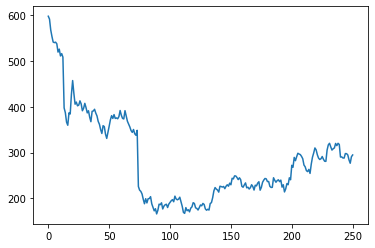

In [ ]:
plt.plot(netflix) 
plt.show()

In [ ]:
# fix random seed for reproducibility
np.random.seed(7)
netflix = netflix.values
netflix = netflix.astype('float32')


In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
netflix = scaler.fit_transform(netflix)


In [ ]:
# split into train and test sets
train_size = int(len(netflix) * 0.70)
test_size = len(netflix) - train_size
train, test = netflix[0:train_size,:], \
              netflix[train_size:len(netflix),:]
print(len(train), len(test))

175 76


In [ ]:
def create_netflix(netflix, look_back=1):
    # convert an array of values into a dataset matrix
    dataX, dataY = [], []
    for i in range(len(netflix)-look_back-1):
        a = netflix[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(netflix[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_netflix(train, look_back)
testX, testY = create_netflix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1,
                                trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
173/173 - 2s - loss: 0.0958 - 2s/epoch - 11ms/step
Epoch 2/100
173/173 - 0s - loss: 0.0479 - 294ms/epoch - 2ms/step
Epoch 3/100
173/173 - 0s - loss: 0.0354 - 326ms/epoch - 2ms/step
Epoch 4/100
173/173 - 0s - loss: 0.0262 - 300ms/epoch - 2ms/step
Epoch 5/100
173/173 - 0s - loss: 0.0181 - 280ms/epoch - 2ms/step
Epoch 6/100
173/173 - 0s - loss: 0.0113 - 304ms/epoch - 2ms/step
Epoch 7/100
173/173 - 0s - loss: 0.0064 - 291ms/epoch - 2ms/step
Epoch 8/100
173/173 - 0s - loss: 0.0034 - 268ms/epoch - 2ms/step
Epoch 9/100
173/173 - 0s - loss: 0.0021 - 281ms/epoch - 2ms/step
Epoch 10/100
173/173 - 0s - loss: 0.0015 - 300ms/epoch - 2ms/step
Epoch 11/100
173/173 - 0s - loss: 0.0014 - 282ms/epoch - 2ms/step
Epoch 12/100
173/173 - 0s - loss: 0.0013 - 288ms/epoch - 2ms/step
Epoch 13/100
173/173 - 0s - loss: 0.0013 - 317ms/epoch - 2ms/step
Epoch 14/100
173/173 - 0s - loss: 0.0013 - 315ms/epoch - 2ms/step
Epoch 15/100
173/173 - 0s - loss: 0.0013 - 290ms/epoch - 2ms/step
Epoch 16/100
173/173 

In [ ]:
#predicting and inverse transforming the predictions
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 5ms/step


In [ ]:
#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 15.50 RMSE
Test Score: 10.61 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(netflix)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(netflix)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(netflix)-1, :] = testPredict


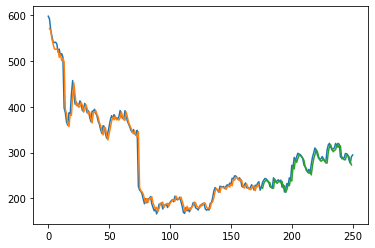

In [ ]:

# plot baseline and predictions
plt.plot(scaler.inverse_transform(netflix))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
#

In [ ]:
#comparison of actual and predicted
actual = np.append(trainY, testY)
predicted = np.append(trainPredict, testPredict)
result_df =pd.DataFrame()
result_df['Actual_Y']= actual
result_df['Predicted_Y']=predicted
print(result_df.head())

     Actual_Y  Predicted_Y
0  591.150039   570.577576
1  567.520023   565.894653
2  553.289987   547.613342
3  541.059989   536.228088
4  539.850008   526.217102
